# Waste Image Classification

This notebook investigates the dataset ([link to Kaggle](https://www.kaggle.com/datasets/quangtheng/garbage-classification-6-classes-775class/)) with images of 6 types of waste: 

* plastic
* paper
* battery
* glass
* organic
* metal

The goal is to predict the type of a waste given its image with a neural network. Since there are multiple image types, this is a multiclass classification problem. Tensorflow is used to design the neural network.

The neural network is constructed using transfer learning, considering 2 types of base models trained on Imagenet: `Xception` and `ResNet50`. A better performing model is further tuned and effective data augmentation is applied. The final model was constructed from `ResNet50` base model with an additional inner layer of 100 neurons and achieved the accuracy of 91% on the validation dataset.

## 0. Library Importing

In [1]:
import os
from PIL import Image

In [2]:
import scipy
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.subplots as sp
import plotly.graph_objects as go
import plotly.io as pio

%matplotlib inline

In [4]:
import tensorflow as tf
import tensorflow.keras as keras

In [5]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input as preprocess_input_xception

In [6]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50

In [8]:
import tensorflow.lite as tflite
from keras_image_helper import create_preprocessor

In [9]:
pio.renderers.default = 'svg' # Comment out this line to make the Plotly graphs interactive

## 1. EDA

Specifying the path to the folder with the images:

In [9]:
data_dir_path = 'data/'

Class names are the subfolder names in the data directory:

In [8]:
class_names = os.listdir(data_dir_path)
class_count = len(class_names)

Let us count the images in each class and display some of them:

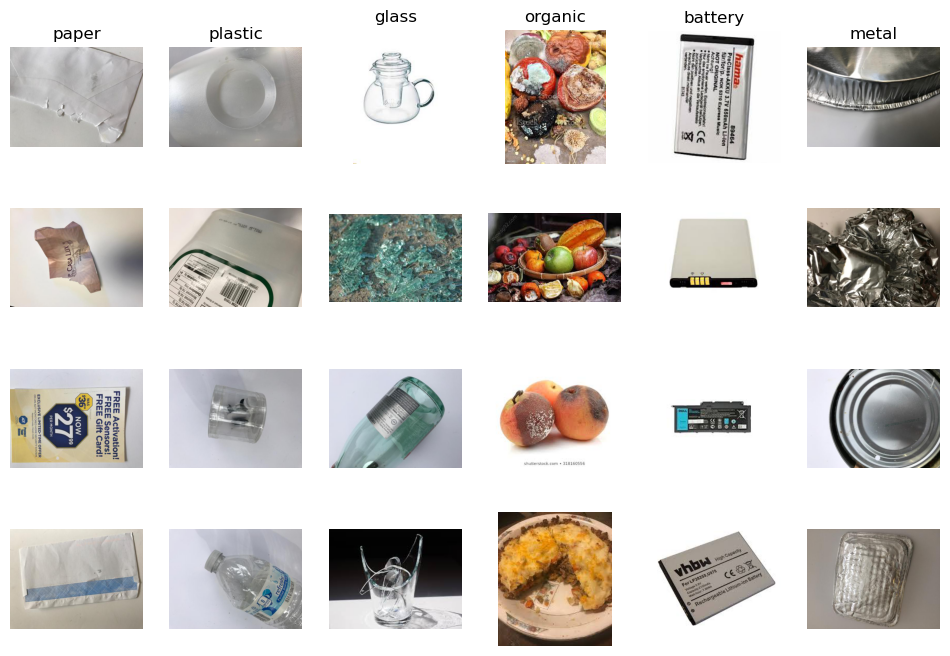

In [8]:
n = 4
img_counts = {}

fig, axes = plt.subplots(n, class_count, figsize=(12, 8))

# Iterate over subfolders:
for class_id, class_name in enumerate(class_names):
    class_dir_path = os.path.join(data_dir_path, class_name)
    
    # Record the number of image files in the current subfolder: 
    imgs = os.listdir(class_dir_path)
    img_counts[class_name] = len(imgs)
    
    # Iterate over first `n` image files in the subfolder:
    for img_id, img_name in enumerate(imgs[:n]):
        img_path = os.path.join(class_dir_path, img_name)
        img = load_img(img_path)
        
        # Display the image in row `img_id` and column `class_id`:
        ax = axes[img_id, class_id]
        ax.imshow(img)
        ax.axis('off')
        
        # Set title to top row of images only to reflect each class:
        if img_id == 0:
            ax.set_title(class_name)

As seen from the above examples, the images have different aspect ratio and background. Some images are off-center.

The author of the dataset claims the data is balanced. Let us confirm this:

In [9]:
img_counts

{'paper': 775,
 'plastic': 775,
 'glass': 775,
 'organic': 775,
 'battery': 775,
 'metal': 775}

Indeed, the dataset is balanced. Let us count the total number of images:

In [10]:
total_img_count = sum(img_counts.values())
total_img_count

4650

Now, let us collect the size and resolution info of the images:

In [11]:
# Initialize empty lists to store the information
img_name_class_pairs = []
sizes = []
resolutions = []

# Iterate over each image file in each subdirectory
for class_dir_path, _, imgs in os.walk(data_dir_path):
    class_name = class_dir_path[5:]
    for img_name in imgs:
        img_name_class_pairs.append((img_name, class_name))
        
        # Load the image file without loading the raster data
        img_path = os.path.join(class_dir_path, img_name)
        img = Image.open(img_path, mode="r")

        # Extract the size of the image
        size = os.path.getsize(img_path)
        sizes.append(size)

        # Extract the resolution of the image
        resolution = img.size
        resolutions.append(resolution)

Converting the above lists to dataframe:

In [12]:
img_df = pd.DataFrame(img_name_class_pairs, columns=['img_name', 'class'])
img_df['size_bytes'] = sizes
img_df['width_px'], img_df['height_px'] = zip(*resolutions)
img_df

,img_name,class,size_bytes,width_px,height_px
0,paper280.jpg,paper,13177,512,384
1,paper669.jpg,paper,11944,512,384
2,paper425.jpg,paper,26478,512,384
3,paper507.jpg,paper,16309,512,384
4,paper568.jpg,paper,22470,512,384
...,...,...,...,...,...
4645,metal610.jpg,metal,5129,240,210
4646,metal608.jpg,metal,10207,275,183
4647,metal320.jpg,metal,19299,512,384
4648,metal663.jpg,metal,3627,225,225


Plotting the size distribution sorted by class:

<AxesSubplot:xlabel='size_bytes', ylabel='Density'>

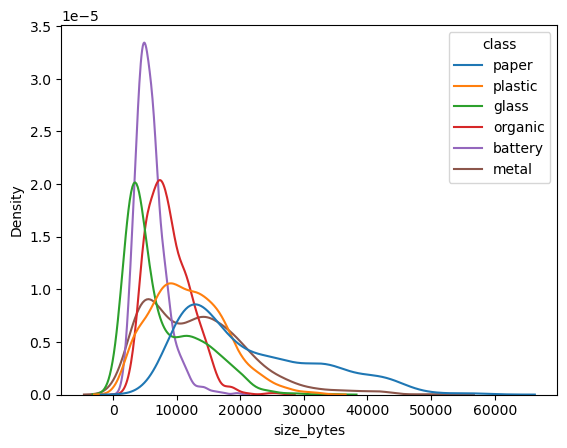

In [13]:
sns.kdeplot(img_df, x='size_bytes', hue='class')

As seen from the above plot, battery and glass classes are mostly the lightest, probably due to them having the least color variation. On the other hand, paper and plastic classes are the heaviest, possibly due to more color variation.

Let us plot the distribution of image resolutions sorted by class:

<AxesSubplot:xlabel='width_px', ylabel='height_px'>

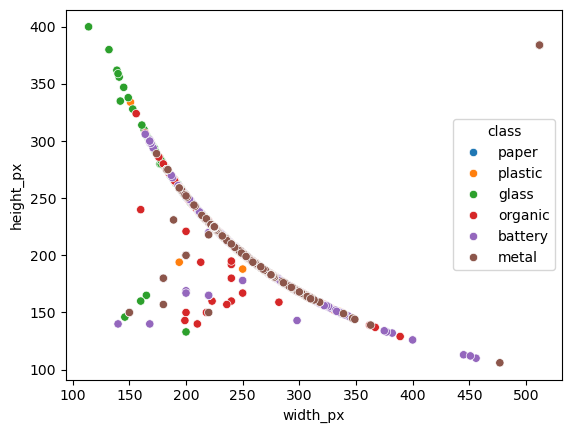

In [14]:
sns.scatterplot(img_df, x="width_px", y="height_px", hue="class")

The images range from ~130 to ~500 pixels in width and from ~130 to ~400 pixels in height. The majority of the images are non-square and their aspect ratio varies significantly. This may affect the accuracy of the model, as the images will have to be rescaled to the same resolution. Also, most of the resolutions lie along an apparent curve, while the other are scattered. This may be the evidence of the dataset being combined from other two datasets.

Finding the mean resolution:

In [15]:
img_df['width_px'].mean(), img_df['height_px'].mean()

(362.1761290322581, 285.3984946236559)

The mean values are close to a square resolution. Therefore, we will use the resolution of 299x299 pixels for training the final model, and the resolution of 150x150 pixels for parameter tuning.

## 2. Model Training

### 2.1. Model Constructor

For selecting the parameters of the model, the images will be supplied in batches of 32 and the resolution of 150x150:

In [13]:
batch_size = 32
img_height = 150
img_width = 150

The function below produces a Keras model, given a pre-trained base model, optimizer learning rate, size of additional inner layer and its dropout rate. There are 6 output neurons corresponding to each class. Categorical cross-entropy is used as the loss function for multiclass classification. No activation is provided for the output and `from_logits=True` is specified for faster training.

In [14]:
def make_model(base_model, learning_rate=0.001, size_inner=None,
               droprate=None):

    base_model.trainable = False
    
    # Generate the vector representation of the base model
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    # Add an optional inner dense layer
    if size_inner is not None:
        inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    else:
        inner = vectors
        
    # Add an optional dropout layer
    if droprate is not None:
        drop = keras.layers.Dropout(droprate)(inner)
    else:
        drop = inner
        
    # Generate the outer dense layer and link the model 
    outputs = keras.layers.Dense(6)(drop)
    model = keras.Model(inputs, outputs)
    
    # Define the optimizer learning rate and the loss function
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

### 2.2. Base Model Comparison

Two Keras models are selected for comparison `Xception` and `ResNet50`, due to their high accuracy and light weight. Since the dataset does not contain very specific images, i.e. the images can be commonly encountered on Imagenet set, the weights of these two base models are selected as pre-trained on Imagenet.

#### 2.2.1. Xception

Performing a 80%-20% train-test split and assigning data generators:

In [78]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_xception,
    validation_split=0.2)

train_ds = train_datagen.flow_from_directory(
    data_dir_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed=23,
    subset='training')

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_xception,
    validation_split=0.2)

val_ds = val_datagen.flow_from_directory(
    data_dir_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=23,
    subset='validation')

Found 3720 images belonging to 6 classes.
Found 930 images belonging to 6 classes.


Specifying the base model:

In [63]:
xception_base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

Compiling the model with default parameters:

In [79]:
model = make_model(xception_base_model)

Initializing an empty dictionary to store the learning curves of the models:

In [80]:
scores = {}

Training the model for 20 epochs and recording its performance:

In [81]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds)
scores['xception'] = history.history

Epoch 1/20
117/117 [==============================] - 13s 91ms/step - loss: 0.5847 - accuracy: 0.8081 - val_loss: 0.6027 - val_accuracy: 0.7774
Epoch 2/20
117/117 [==============================] - 10s 85ms/step - loss: 0.2818 - accuracy: 0.9081 - val_loss: 0.5052 - val_accuracy: 0.8097
Epoch 3/20
117/117 [==============================] - 10s 86ms/step - loss: 0.2094 - accuracy: 0.9358 - val_loss: 0.4802 - val_accuracy: 0.8204
Epoch 4/20
117/117 [==============================] - 10s 84ms/step - loss: 0.1711 - accuracy: 0.9511 - val_loss: 0.4442 - val_accuracy: 0.8269
Epoch 5/20
117/117 [==============================] - 10s 86ms/step - loss: 0.1405 - accuracy: 0.9613 - val_loss: 0.4582 - val_accuracy: 0.8355
Epoch 6/20
117/117 [==============================] - 10s 84ms/step - loss: 0.1190 - accuracy: 0.9691 - val_loss: 0.4334 - val_accuracy: 0.8398
Epoch 7/20
117/117 [==============================] - 10s 85ms/step - loss: 0.1034 - accuracy: 0.9728 - val_loss: 0.4425 - val_accuracy:

#### 2.2.2. ResNet50

Below are the same steps described in Section 2.2.1, now for the ResNet50 base model:

In [87]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_resnet50,
    validation_split=0.2)

train_ds = train_datagen.flow_from_directory(
    data_dir_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed=23,
    subset='training')

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_resnet50,
    validation_split=0.2)

val_ds = val_datagen.flow_from_directory(
    data_dir_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=23,
    subset='validation')

Found 3720 images belonging to 6 classes.
Found 930 images belonging to 6 classes.


In [71]:
resnet50_base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

In [83]:
model = make_model(resnet50_base_model)

In [84]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds)
scores['resnet50'] = history.history

Epoch 1/20
117/117 [==============================] - 14s 95ms/step - loss: 0.5454 - accuracy: 0.8099 - val_loss: 0.5135 - val_accuracy: 0.8022
Epoch 2/20
117/117 [==============================] - 10s 87ms/step - loss: 0.1954 - accuracy: 0.9358 - val_loss: 0.4200 - val_accuracy: 0.8473
Epoch 3/20
117/117 [==============================] - 10s 86ms/step - loss: 0.1275 - accuracy: 0.9583 - val_loss: 0.3750 - val_accuracy: 0.8710
Epoch 4/20
117/117 [==============================] - 10s 86ms/step - loss: 0.0877 - accuracy: 0.9753 - val_loss: 0.3723 - val_accuracy: 0.8731
Epoch 5/20
117/117 [==============================] - 10s 87ms/step - loss: 0.0689 - accuracy: 0.9828 - val_loss: 0.4183 - val_accuracy: 0.8581
Epoch 6/20
117/117 [==============================] - 10s 86ms/step - loss: 0.0529 - accuracy: 0.9895 - val_loss: 0.3690 - val_accuracy: 0.8731
Epoch 7/20
117/117 [==============================] - 10s 87ms/step - loss: 0.0413 - accuracy: 0.9935 - val_loss: 0.4070 - val_accuracy:

#### 2.2.3. Selection

Let us plot the learning curves of each model:

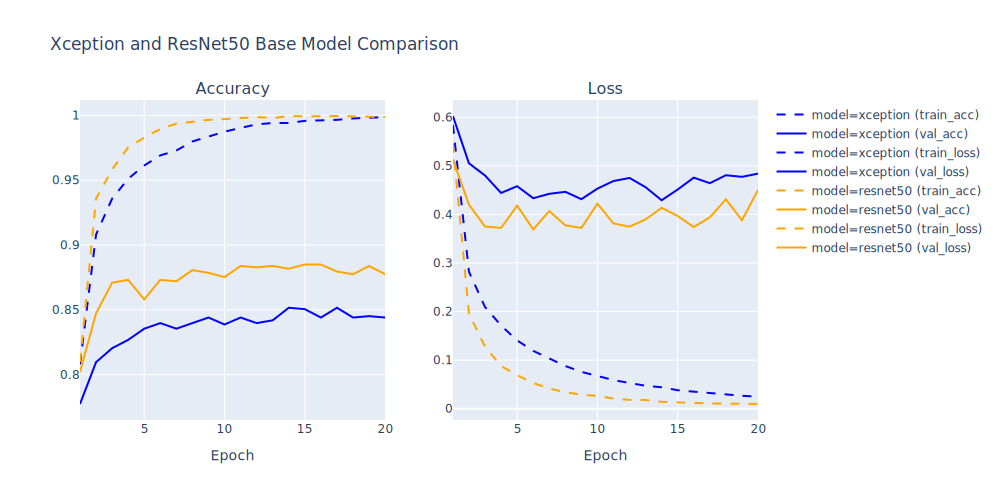

In [85]:
colors = ['blue', 'orange']
epochs = list(range(1, 21))

fig = sp.make_subplots(rows=1, cols=2, subplot_titles=['Accuracy', 'Loss'])

for model, color in zip(scores, colors):
    fig.add_trace(go.Scatter(x=epochs, y=scores[model]['accuracy'],
                             mode='lines', name=f'model={model} (train_acc)', 
                             line=dict(color=color, dash='dash')), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=scores[model]['val_accuracy'], 
                             mode='lines', name=f'model={model} (val_acc)',  
                             line=dict(color=color)), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=scores[model]['loss'], 
                             mode='lines', name=f'model={model} (train_loss)',  
                             line=dict(color=color, dash='dash')), row=1, col=2)
    fig.add_trace(go.Scatter(x=epochs, y=scores[model]['val_loss'],  
                             mode='lines', name=f'model={model} (val_loss)', 
                             line=dict(color=color)), row=1, col=2)
    
fig.update_layout(title="Xception and ResNet50 Base Model Comparison",
                 width=1000, height=500)
fig['layout']['xaxis']['title']='Epoch'
fig['layout']['xaxis2']['title']='Epoch'

fig.show()

As seen from the plot, ResNet50 model achieves a higher accuracy and maintains a lower loss, so it is selected as the base model. It, however, learns quite fast and does not improve the accuracy after 10 epochs. We attempt to improve this in further sections.

### 2.3. Tuning Learning Rate

Let us save the score with the default learning rate, so we do not have to re-evaluate the model for this rate:

In [86]:
hist_default_lr = scores['resnet50']

The scores of the models with learning rates of 0.0001, 0.001, 0.01, 0.1 are obtained below:

In [88]:
scores = {}
scores[0.001] = hist_default_lr

for lr in [0.0001, 0.01, 0.1]:
    print('learning_rate=%s' % lr)

    model = make_model(resnet50_base_model, learning_rate=lr)
    history = model.fit(train_ds, epochs=20, validation_data=val_ds)
    scores[lr] = history.history

    print()
    print()
    
scores = dict(sorted(scores.items()))

learning_rate=0.0001
Epoch 1/20
117/117 [==============================] - 13s 93ms/step - loss: 1.5812 - accuracy: 0.4269 - val_loss: 1.2981 - val_accuracy: 0.5312
Epoch 2/20
117/117 [==============================] - 10s 86ms/step - loss: 0.6935 - accuracy: 0.7626 - val_loss: 0.9483 - val_accuracy: 0.6710
Epoch 3/20
117/117 [==============================] - 10s 87ms/step - loss: 0.4789 - accuracy: 0.8403 - val_loss: 0.7973 - val_accuracy: 0.7237
Epoch 4/20
117/117 [==============================] - 10s 87ms/step - loss: 0.3812 - accuracy: 0.8766 - val_loss: 0.7156 - val_accuracy: 0.7473
Epoch 5/20
117/117 [==============================] - 10s 86ms/step - loss: 0.3220 - accuracy: 0.8984 - val_loss: 0.6680 - val_accuracy: 0.7656
Epoch 6/20
117/117 [==============================] - 10s 88ms/step - loss: 0.2840 - accuracy: 0.9137 - val_loss: 0.6004 - val_accuracy: 0.7849
Epoch 7/20
117/117 [==============================] - 10s 86ms/step - loss: 0.2537 - accuracy: 0.9239 - val_loss: 0

Let us plot the accuracy and loss curves for each learning rate:

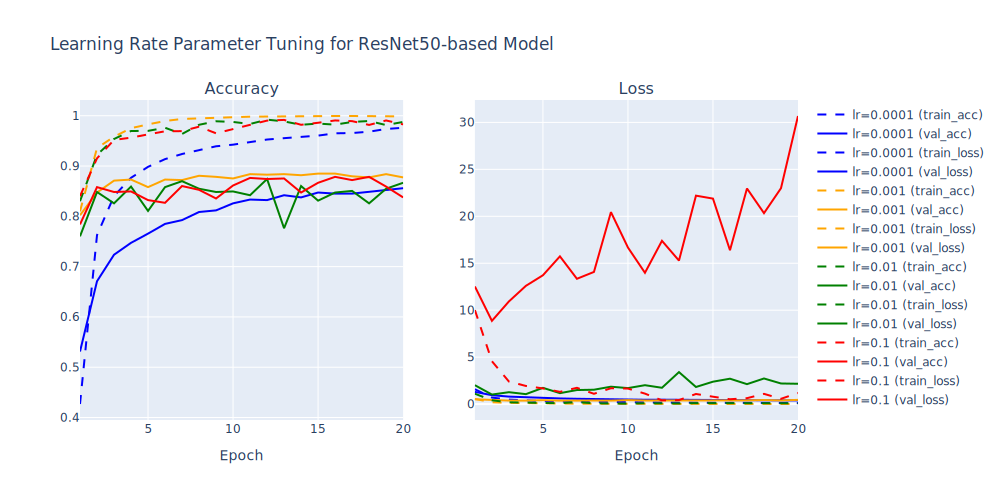

In [92]:
colors = ['blue', 'orange', 'green', 'red']
epochs = list(range(1, 21))

fig = sp.make_subplots(rows=1, cols=2, subplot_titles=['Accuracy', 'Loss'])

for lr, color in zip(scores, colors):
    fig.add_trace(go.Scatter(x=epochs, y=scores[lr]['accuracy'],
                             mode='lines', name=f'lr={lr} (train_acc)', 
                             line=dict(color=color, dash='dash')), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=scores[lr]['val_accuracy'], 
                             mode='lines', name=f'lr={lr} (val_acc)',  
                             line=dict(color=color)), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=scores[lr]['loss'], 
                             mode='lines', name=f'lr={lr} (train_loss)',  
                             line=dict(color=color, dash='dash')), row=1, col=2)
    fig.add_trace(go.Scatter(x=epochs, y=scores[lr]['val_loss'],  
                             mode='lines', name=f'lr={lr} (val_loss)', 
                             line=dict(color=color)), row=1, col=2)
    
fig.update_layout(title="Learning Rate Parameter Tuning for ResNet50-based Model",
                 width=1000, height=500)
fig['layout']['xaxis']['title']='Epoch'
fig['layout']['xaxis2']['title']='Epoch'

fig.show()

As seen from the above plot, the validation loss for the learning rate of 0.1 increases rapidly. The growth in validation loss can also be observed for the learning rate of 0.01, except with a lower intensity. The learning rate of 0.001 achieves the highest accuracy, but its growth stops rather fast (same with the drop in loss). The curve for the learning rate of 0.0001 achieves a lower accuracy in 20 epochs, but still keeps improving. Therefore, a middle value of 0.0005 is selected as the optimal learning rate for further tuning.

### 2.4. Tuning Size of Inner Layer

The scores of the models with inner layer size of 0, 10, 100, 1000 neurons are obtained below:

In [21]:
learning_rate = 0.0005

scores = {}

for size in [None, 10, 100, 1000]:
    print('size_inner=%s' % size)

    model = make_model(resnet50_base_model, learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=20, validation_data=val_ds)
    scores[size] = history.history

    print()
    print()

size_inner=None
Epoch 1/20
117/117 [==============================] - 18s 126ms/step - loss: 0.6666 - accuracy: 0.7613 - val_loss: 0.6695 - val_accuracy: 0.7559
Epoch 2/20
117/117 [==============================] - 14s 117ms/step - loss: 0.2570 - accuracy: 0.9175 - val_loss: 0.5370 - val_accuracy: 0.8075
Epoch 3/20
117/117 [==============================] - 14s 120ms/step - loss: 0.1829 - accuracy: 0.9398 - val_loss: 0.4672 - val_accuracy: 0.8344
Epoch 4/20
117/117 [==============================] - 13s 114ms/step - loss: 0.1429 - accuracy: 0.9578 - val_loss: 0.4238 - val_accuracy: 0.8473
Epoch 5/20
117/117 [==============================] - 14s 118ms/step - loss: 0.1165 - accuracy: 0.9667 - val_loss: 0.4133 - val_accuracy: 0.8645
Epoch 6/20
117/117 [==============================] - 14s 117ms/step - loss: 0.0955 - accuracy: 0.9755 - val_loss: 0.3958 - val_accuracy: 0.8731
Epoch 7/20
117/117 [==============================] - 14s 116ms/step - loss: 0.0815 - accuracy: 0.9828 - val_loss:

Epoch 17/20
117/117 [==============================] - 14s 116ms/step - loss: 0.0082 - accuracy: 0.9992 - val_loss: 0.5280 - val_accuracy: 0.8731
Epoch 18/20
117/117 [==============================] - 14s 116ms/step - loss: 0.0092 - accuracy: 0.9992 - val_loss: 0.4837 - val_accuracy: 0.8849
Epoch 19/20
117/117 [==============================] - 14s 119ms/step - loss: 0.0100 - accuracy: 0.9987 - val_loss: 0.4741 - val_accuracy: 0.8925
Epoch 20/20
117/117 [==============================] - 14s 117ms/step - loss: 0.0081 - accuracy: 0.9992 - val_loss: 0.4957 - val_accuracy: 0.8892


size_inner=1000
Epoch 1/20
117/117 [==============================] - 19s 126ms/step - loss: 0.4030 - accuracy: 0.8710 - val_loss: 0.5025 - val_accuracy: 0.8269
Epoch 2/20
117/117 [==============================] - 14s 117ms/step - loss: 0.1025 - accuracy: 0.9656 - val_loss: 0.3853 - val_accuracy: 0.8720
Epoch 3/20
117/117 [==============================] - 14s 116ms/step - loss: 0.0365 - accuracy: 0.9895 - val

Let us plot the accuracy and loss curves for each size:

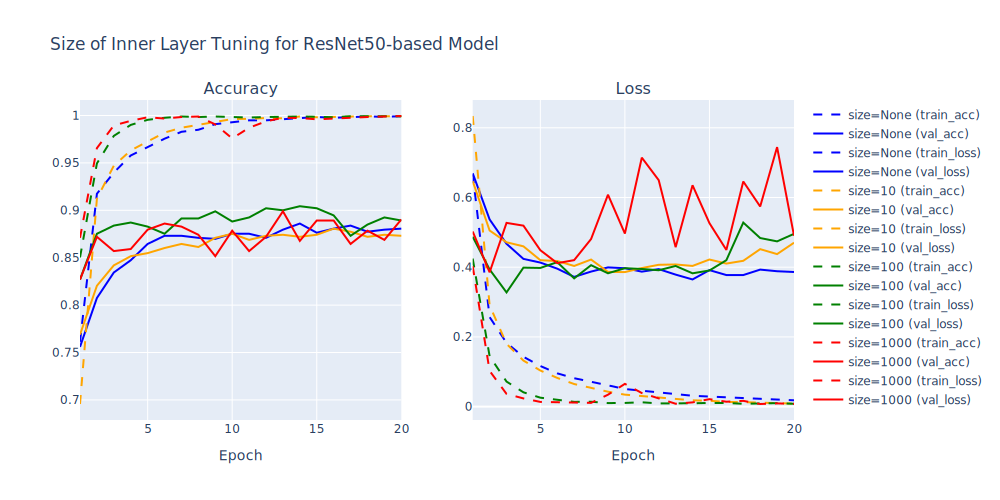

In [24]:
colors = ['blue', 'orange', 'green', 'red']
epochs = list(range(1, 21))

fig = sp.make_subplots(rows=1, cols=2, subplot_titles=['Accuracy', 'Loss'])

for size, color in zip(scores, colors):
    fig.add_trace(go.Scatter(x=epochs, y=scores[size]['accuracy'],
                             mode='lines', name=f'size={size} (train_acc)', 
                             line=dict(color=color, dash='dash')), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=scores[size]['val_accuracy'], 
                             mode='lines', name=f'size={size} (val_acc)',  
                             line=dict(color=color)), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=scores[size]['loss'], 
                             mode='lines', name=f'size={size} (train_loss)',  
                             line=dict(color=color, dash='dash')), row=1, col=2)
    fig.add_trace(go.Scatter(x=epochs, y=scores[size]['val_loss'],  
                             mode='lines', name=f'size={size} (val_loss)', 
                             line=dict(color=color)), row=1, col=2)
    
fig.update_layout(title="Size of Inner Layer Tuning for ResNet50-based Model",
                 width=1000, height=500)
fig['layout']['xaxis']['title']='Epoch'
fig['layout']['xaxis2']['title']='Epoch'

fig.show()

As seen from the plot, the highest validation accuracy is achieved with 100 neurons. However, in this case, the validation loss increases after 10 epochs. We attempt to counteract this using dropout and data augmentation in the following sections. 

### 2.5. Tuning Dropout Rate

Let us save the score with the selected inner layer size:

In [31]:
hist_no_droprate = scores[100]

The scores of the models with dropout rates of 0, 0.2, 0.5, 0.8 are obtained below:

In [32]:
learning_rate = 0.0005
size = 100

scores = {}
scores[0.0] = hist_no_droprate

for droprate in [0.2, 0.5, 0.8]:    
    print('droprate=%s' % droprate)

    model = make_model(resnet50_base_model, 
                       learning_rate=learning_rate,
                       size_inner=size,
                       droprate=droprate
                      )
    
    history = model.fit(train_ds, epochs=20, validation_data=val_ds)
    scores[droprate] = history.history

    print()
    print()

droprate=0.2
Epoch 1/20
117/117 [==============================] - 14s 97ms/step - loss: 0.4939 - accuracy: 0.8245 - val_loss: 0.4623 - val_accuracy: 0.8183
Epoch 2/20
117/117 [==============================] - 11s 90ms/step - loss: 0.1892 - accuracy: 0.9328 - val_loss: 0.3689 - val_accuracy: 0.8720
Epoch 3/20
117/117 [==============================] - 11s 91ms/step - loss: 0.1151 - accuracy: 0.9613 - val_loss: 0.4536 - val_accuracy: 0.8677
Epoch 4/20
117/117 [==============================] - 10s 89ms/step - loss: 0.0811 - accuracy: 0.9753 - val_loss: 0.4433 - val_accuracy: 0.8613
Epoch 5/20
117/117 [==============================] - 11s 90ms/step - loss: 0.0594 - accuracy: 0.9839 - val_loss: 0.4478 - val_accuracy: 0.8602
Epoch 6/20
117/117 [==============================] - 11s 90ms/step - loss: 0.0446 - accuracy: 0.9890 - val_loss: 0.3402 - val_accuracy: 0.8849
Epoch 7/20
117/117 [==============================] - 10s 89ms/step - loss: 0.0401 - accuracy: 0.9890 - val_loss: 0.3969 - 

Let us plot the accuracy and loss curves for each dropout rate:

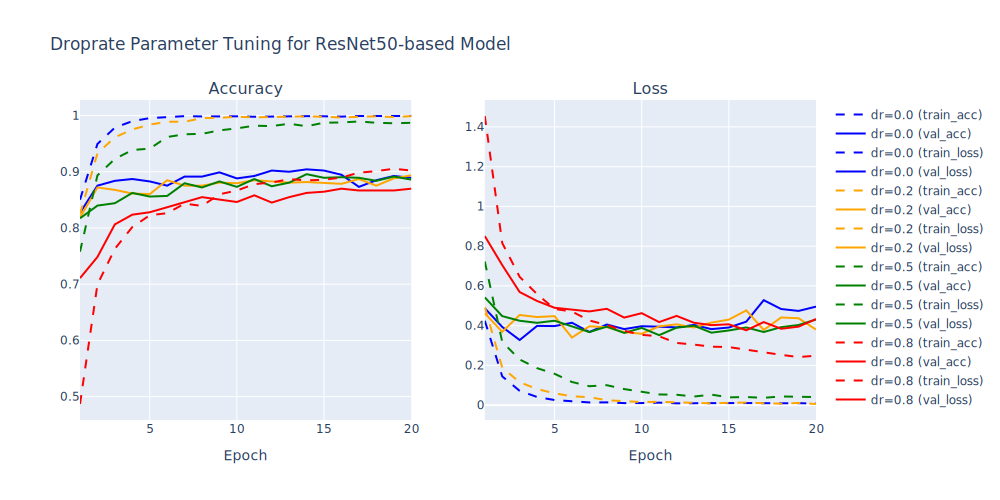

In [36]:
colors = ['blue', 'orange', 'green', 'red']
epochs = list(range(1, 21))

fig = sp.make_subplots(rows=1, cols=2, subplot_titles=['Accuracy', 'Loss'])

for dr, color in zip(scores, colors):
    fig.add_trace(go.Scatter(x=epochs, y=scores[dr]['accuracy'],
                             mode='lines', name=f'dr={dr} (train_acc)', 
                             line=dict(color=color, dash='dash')), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=scores[dr]['val_accuracy'], 
                             mode='lines', name=f'dr={dr} (val_acc)',  
                             line=dict(color=color)), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=scores[dr]['loss'], 
                             mode='lines', name=f'dr={dr} (train_loss)',  
                             line=dict(color=color, dash='dash')), row=1, col=2)
    fig.add_trace(go.Scatter(x=epochs, y=scores[dr]['val_loss'],  
                             mode='lines', name=f'dr={dr} (val_loss)', 
                             line=dict(color=color)), row=1, col=2)
    
fig.update_layout(title="Droprate Parameter Tuning for ResNet50-based Model",
                 width=1000, height=500)
fig['layout']['xaxis']['title']='Epoch'
fig['layout']['xaxis2']['title']='Epoch'

fig.show()

As seen from above, droprates other than zero produce no improvement in accuracy relative to the default base model. Therefore, zero droprate is selected for further tuning, and the increase in loss will be fought against with data augmentation.

### 2.6. Selecting Data Augmentation

Let us save the score with the selected dropout rate:

In [37]:
hist_no_aug = scores[0.0]

The following data augmentation parameters are selected for testing:

* `rotation_range=40`
* `width_shift_range=0.2`
* `height_shift_range=0.2`
* `shear_range=0.2`

We will train models by applying each of these data augmentations separately. The ones that perform better relative to the model with no data augmentation, will be selected for the final model.

Let us begin by training a model with `rotation_range=40`:

In [94]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_resnet50,
    validation_split=0.2,
    rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
)

train_ds = train_datagen.flow_from_directory(
    data_dir_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed=23,
    subset='training')

Found 3720 images belonging to 6 classes.


In [95]:
learning_rate = 0.0005
size = 100
droprate = 0.0

scores = {}
scores['no_aug'] = hist_no_aug

model = make_model(resnet50_base_model, 
                   learning_rate=learning_rate,
                   size_inner=size,
                   droprate=droprate
                  )

history = model.fit(train_ds, epochs=20, validation_data=val_ds)
scores['rotation'] = history.history

Epoch 1/20
117/117 [==============================] - 27s 208ms/step - loss: 0.5244 - accuracy: 0.8129 - val_loss: 0.4446 - val_accuracy: 0.8290
Epoch 2/20
117/117 [==============================] - 23s 199ms/step - loss: 0.2129 - accuracy: 0.9242 - val_loss: 0.4664 - val_accuracy: 0.8430
Epoch 3/20
117/117 [==============================] - 23s 200ms/step - loss: 0.1696 - accuracy: 0.9384 - val_loss: 0.4720 - val_accuracy: 0.8527
Epoch 4/20
117/117 [==============================] - 23s 200ms/step - loss: 0.1264 - accuracy: 0.9556 - val_loss: 0.4168 - val_accuracy: 0.8581
Epoch 5/20
117/117 [==============================] - 23s 199ms/step - loss: 0.0932 - accuracy: 0.9699 - val_loss: 0.4556 - val_accuracy: 0.8581
Epoch 6/20
117/117 [==============================] - 23s 199ms/step - loss: 0.0879 - accuracy: 0.9683 - val_loss: 0.4574 - val_accuracy: 0.8430
Epoch 7/20
117/117 [==============================] - 23s 199ms/step - loss: 0.0737 - accuracy: 0.9739 - val_loss: 0.3810 - val_ac

Training a model with `width_shift_range=0.2`:

In [97]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_resnet50,
    validation_split=0.2,
#     rotation_range=40,
    width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
)

train_ds = train_datagen.flow_from_directory(
    data_dir_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed=23,
    subset='training')

Found 3720 images belonging to 6 classes.


In [98]:
model = make_model(resnet50_base_model, 
                   learning_rate=learning_rate,
                   size_inner=size,
                   droprate=droprate
                  )

history = model.fit(train_ds, epochs=20, validation_data=val_ds)
scores['width_shift'] = history.history

Epoch 1/20
117/117 [==============================] - 27s 207ms/step - loss: 0.4559 - accuracy: 0.8438 - val_loss: 0.5652 - val_accuracy: 0.8065
Epoch 2/20
117/117 [==============================] - 24s 201ms/step - loss: 0.1897 - accuracy: 0.9339 - val_loss: 0.4517 - val_accuracy: 0.8419
Epoch 3/20
117/117 [==============================] - 23s 200ms/step - loss: 0.1249 - accuracy: 0.9559 - val_loss: 0.4720 - val_accuracy: 0.8430
Epoch 4/20
117/117 [==============================] - 23s 198ms/step - loss: 0.0846 - accuracy: 0.9745 - val_loss: 0.4481 - val_accuracy: 0.8559
Epoch 5/20
117/117 [==============================] - 24s 201ms/step - loss: 0.0651 - accuracy: 0.9788 - val_loss: 0.4043 - val_accuracy: 0.8710
Epoch 6/20
117/117 [==============================] - 24s 201ms/step - loss: 0.0529 - accuracy: 0.9833 - val_loss: 0.3651 - val_accuracy: 0.8892
Epoch 7/20
117/117 [==============================] - 24s 201ms/step - loss: 0.0390 - accuracy: 0.9903 - val_loss: 0.4543 - val_ac

Training a model with `height_shift_range=0.2`:

In [99]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_resnet50,
    validation_split=0.2,
#     rotation_range=40,
#     width_shift_range=0.2,
    height_shift_range=0.2,
#     shear_range=0.2,
)

train_ds = train_datagen.flow_from_directory(
    data_dir_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed=23,
    subset='training')

Found 3720 images belonging to 6 classes.


In [100]:
model = make_model(resnet50_base_model, 
                   learning_rate=learning_rate,
                   size_inner=size,
                   droprate=droprate
                  )

history = model.fit(train_ds, epochs=20, validation_data=val_ds)
scores['height_shift'] = history.history

Epoch 1/20
117/117 [==============================] - 27s 206ms/step - loss: 0.4126 - accuracy: 0.8538 - val_loss: 0.4398 - val_accuracy: 0.8462
Epoch 2/20
117/117 [==============================] - 24s 201ms/step - loss: 0.1651 - accuracy: 0.9435 - val_loss: 0.4108 - val_accuracy: 0.8495
Epoch 3/20
117/117 [==============================] - 24s 201ms/step - loss: 0.0989 - accuracy: 0.9715 - val_loss: 0.3558 - val_accuracy: 0.8742
Epoch 4/20
117/117 [==============================] - 24s 201ms/step - loss: 0.0784 - accuracy: 0.9745 - val_loss: 0.3719 - val_accuracy: 0.8742
Epoch 5/20
117/117 [==============================] - 23s 200ms/step - loss: 0.0635 - accuracy: 0.9780 - val_loss: 0.3212 - val_accuracy: 0.8914
Epoch 6/20
117/117 [==============================] - 23s 200ms/step - loss: 0.0402 - accuracy: 0.9884 - val_loss: 0.3485 - val_accuracy: 0.8882
Epoch 7/20
117/117 [==============================] - 23s 200ms/step - loss: 0.0354 - accuracy: 0.9917 - val_loss: 0.3556 - val_ac

Training a model with `shear_range=0.2`:

In [101]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_resnet50,
    validation_split=0.2,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
    shear_range=0.2,
)

train_ds = train_datagen.flow_from_directory(
    data_dir_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed=23,
    subset='training')

Found 3720 images belonging to 6 classes.


In [102]:
model = make_model(resnet50_base_model, 
                   learning_rate=learning_rate,
                   size_inner=size,
                   droprate=droprate
                  )

history = model.fit(train_ds, epochs=20, validation_data=val_ds)
scores['shear'] = history.history

Epoch 1/20
117/117 [==============================] - 27s 207ms/step - loss: 0.4400 - accuracy: 0.8454 - val_loss: 0.4733 - val_accuracy: 0.8301
Epoch 2/20
117/117 [==============================] - 23s 195ms/step - loss: 0.1621 - accuracy: 0.9449 - val_loss: 0.5279 - val_accuracy: 0.8237
Epoch 3/20
117/117 [==============================] - 23s 196ms/step - loss: 0.0767 - accuracy: 0.9758 - val_loss: 0.4078 - val_accuracy: 0.8624
Epoch 4/20
117/117 [==============================] - 23s 196ms/step - loss: 0.0418 - accuracy: 0.9914 - val_loss: 0.4253 - val_accuracy: 0.8624
Epoch 5/20
117/117 [==============================] - 23s 196ms/step - loss: 0.0259 - accuracy: 0.9965 - val_loss: 0.3812 - val_accuracy: 0.8720
Epoch 6/20
117/117 [==============================] - 23s 196ms/step - loss: 0.0197 - accuracy: 0.9976 - val_loss: 0.3828 - val_accuracy: 0.8796
Epoch 7/20
117/117 [==============================] - 23s 196ms/step - loss: 0.0127 - accuracy: 0.9989 - val_loss: 0.3985 - val_ac

Plotting the results for each data augmentation:

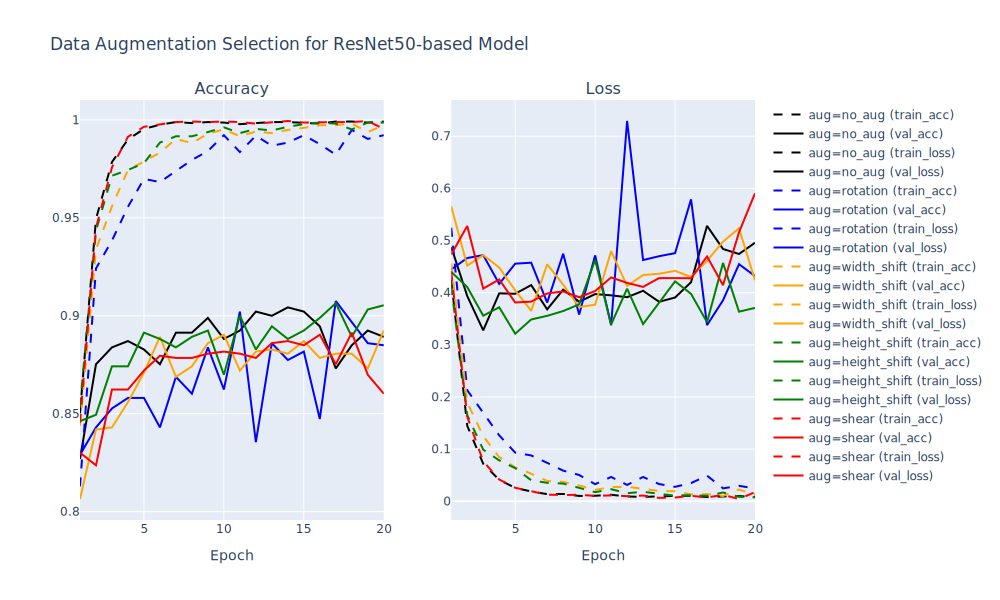

In [109]:
colors = ['black', 'blue', 'orange', 'green', 'red']
epochs = list(range(1, 21))

fig = sp.make_subplots(rows=1, cols=2, subplot_titles=['Accuracy', 'Loss'])

for aug, color in zip(scores, colors):
    fig.add_trace(go.Scatter(x=epochs, y=scores[aug]['accuracy'],
                             mode='lines', name=f'aug={aug} (train_acc)', 
                             line=dict(color=color, dash='dash')), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=scores[aug]['val_accuracy'], 
                             mode='lines', name=f'aug={aug} (val_acc)',  
                             line=dict(color=color)), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=scores[aug]['loss'], 
                             mode='lines', name=f'aug={aug} (train_loss)',  
                             line=dict(color=color, dash='dash')), row=1, col=2)
    fig.add_trace(go.Scatter(x=epochs, y=scores[aug]['val_loss'],  
                             mode='lines', name=f'aug={aug} (val_loss)', 
                             line=dict(color=color)), row=1, col=2)
    
fig.update_layout(title="Data Augmentation Selection for ResNet50-based Model",
                 width=1000, height=600)
fig['layout']['xaxis']['title']='Epoch'
fig['layout']['xaxis2']['title']='Epoch'

fig.show()

As seen from the plot, height shift produced an increase in validation accuracy and a decrease in loss relative to the no augmentation model. Rotation was also able to yield a higher accuracy twice, but it is generally lower and the associated learning curve is very unstable. Thus, height shift alone is chosen for training the final model.

### 2.7. Final Model

For training the model, the images will come in 299x299 resolution:

In [10]:
batch_size = 32
img_height = 299
img_width = 299

Performing the train-test split with the final parameters:

In [11]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_resnet50,
    validation_split=0.2,
    height_shift_range=0.2,
)

train_ds = train_datagen.flow_from_directory(
    data_dir_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed=23,
    subset='training')

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_resnet50,
    validation_split=0.2)

val_ds = val_datagen.flow_from_directory(
    data_dir_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=23,
    subset='validation')

Found 3720 images belonging to 6 classes.
Found 930 images belonging to 6 classes.


Updating the input shape of the base model:

In [112]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(img_width, img_height, 3)
)

base_model.trainable = False

Compiling the final model with the selected parameters. This time, `softmax` activation is applied to the output to produce the probability of belonging to a particular class:

In [113]:
learning_rate = 0.0005
size_inner = 100
droprate = 0.0

inputs = keras.Input(shape=(img_width, img_height, 3))
base = base_model(inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
drop = keras.layers.Dropout(droprate)(inner)
outputs = keras.layers.Dense(6, activation='softmax')(drop)
model = keras.Model(inputs, outputs)

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)

Defining a checkpoint based on maximum validation accuracy:

In [114]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'resnet50_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

Training the final model for 50 epochs:

In [115]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds, 
                   callbacks=[checkpoint])

Epoch 1/50
117/117 [==============================] - 77s 623ms/step - loss: 0.4319 - accuracy: 0.8565 - val_loss: 0.5171 - val_accuracy: 0.8301
Epoch 2/50
117/117 [==============================] - 72s 612ms/step - loss: 0.1582 - accuracy: 0.9444 - val_loss: 0.3735 - val_accuracy: 0.8645
Epoch 3/50
117/117 [==============================] - 71s 609ms/step - loss: 0.1057 - accuracy: 0.9618 - val_loss: 0.3030 - val_accuracy: 0.8903
Epoch 4/50
117/117 [==============================] - 71s 608ms/step - loss: 0.0834 - accuracy: 0.9731 - val_loss: 0.2951 - val_accuracy: 0.8935
Epoch 5/50
117/117 [==============================] - 71s 606ms/step - loss: 0.0599 - accuracy: 0.9828 - val_loss: 0.3336 - val_accuracy: 0.8860
Epoch 6/50
117/117 [==============================] - 71s 608ms/step - loss: 0.0450 - accuracy: 0.9879 - val_loss: 0.2542 - val_accuracy: 0.9065
Epoch 7/50
117/117 [==============================] - 71s 606ms/step - loss: 0.0357 - accuracy: 0.9909 - val_loss: 0.3024 - val_ac

KeyboardInterrupt: 

Training was interrupted manually, since the accuracy stopped substantially improving after 10 epochs. The final model was selected to be `resnet50_09_0.912.h5` achieving 91.2% validation accuracy on epoch 9.

## 3. Model Saving and Testing

Let us load the final model and view its structure:

In [13]:
model = keras.models.load_model('resnet50_09_0.912.h5')

In [14]:
model.summary()

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 global_average_pooling2d_33  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_52 (Dense)            (None, 100)               204900    
                                                                 
 dropout_16 (Dropout)        (None, 100)               0         
                                                                 
 dense_53 (Dense)            (None, 6)                 606       
                                                          

Loading the test image (not from the dataset):

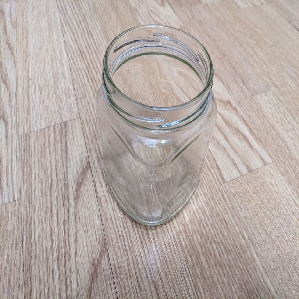

In [15]:
img_test = load_img('jar.jpg', target_size=(299, 299))
img_test

Preprocessing the image and predicting its class:

In [16]:
x = np.array(img_test)
X = np.array([x])
X = preprocess_input_resnet50(X)

In [18]:
pred = model.predict(X)

1/1 [==============================] - 0s 29ms/step


In [19]:
class_names = train_ds.class_indices.keys()

In [20]:
dict(zip(class_names, pred[0]))

{'battery': 6.012203e-07,
 'glass': 0.9922086,
 'metal': 0.0002583109,
 'organic': 0.0005711895,
 'paper': 0.00062860723,
 'plastic': 0.0063326205}

The result suggests that this is an image of glass with 99.2% probability.

Let us convert the model to `.tflite` format for later deployment:

In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open('waste-model.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpfn6fa1ti/assets


INFO:tensorflow:Assets written to: /tmp/tmpfn6fa1ti/assets
2024-01-19 15:59:39.020629: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-01-19 15:59:39.020675: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-01-19 15:59:39.020852: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpfn6fa1ti
2024-01-19 15:59:39.056916: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2024-01-19 15:59:39.056961: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmpfn6fa1ti
2024-01-19 15:59:39.216704: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2024-01-19 15:59:39.987071: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpfn6fa1ti
2024-01-19 15:59:40.295469: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

Setting the input and output indices of the interpreter:

In [24]:
interpreter = tflite.Interpreter(model_path='waste-model.tflite')
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

Predicting the same image again, now with the TFLITE model:

In [25]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()
pred = interpreter.get_tensor(output_index)

In [26]:
dict(zip(class_names, pred[0]))

{'battery': 6.012237e-07,
 'glass': 0.9922086,
 'metal': 0.00025831186,
 'organic': 0.00057119114,
 'paper': 0.00062861,
 'plastic': 0.006332617}

The results are the same as before.

Finally, to run completely independent from Tensorflow (`tflite` will be installed separately), we use the ResNet50 preprocessing function from `keras_image_helper`: 

In [27]:
preprocessor = create_preprocessor('resnet50', target_size=(299, 299))

Classifying the same image again:

In [28]:
X = preprocessor.from_path('jar.jpg')

In [29]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()
pred = interpreter.get_tensor(output_index)

In [30]:
dict(zip(class_names, pred[0]))

{'battery': 6.012237e-07,
 'glass': 0.9922086,
 'metal': 0.00025831186,
 'organic': 0.00057119114,
 'paper': 0.00062861,
 'plastic': 0.006332617}

The same results are obtained. This model will be used for deployment.